
# <div align="center"> **WALMART SALES <br>Analysis & Forecast** </div>


#### <div align="center"> **Problem Statement** <br> </div>

Walmart is a retail chain with 45 given stores.<br>
We have their weekly recorded sales from 05-02-2010 till 26-10-2012.<br>
We must use the given 8 features to build a model and predict future sales. <br>

#### <div align="center"> **Solution Objectives** <br> </div>
- **Analyze** the effect of the features provided on the weekly recorded sales (**EDA**)
  
- **Forecast** the next twelve weeks of sales (**Prediction/Evaluation**)


#### <div align="center"> **Table of Contents** <br> </div>
- Preprocessing/Exploratory Data Analysis (EDA)
- Modeling with Forecasting Analysis (SARIMA)
- Project Outcomes & Conclusion

#### <div align="center"> **1. PreProcessing/EDA** </div>

#### a. Relevant Imports:

In [72]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, math

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import preprocessing

from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose as season
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.2f}'.format)

#### b. Read Data:

In [2]:
df = pd.read_csv('Walmart.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


#### Features:
   
   - Store : numbered 1-45

   - Date: (must convert to datetime) 05022010 to 26202012 weekly
  
   - Weekly_Sales: continuous weekly sales
  
   - Holiday_Flag: binary holiday yes or no for row's date
  
   - Temperature: continuous 
  
   - Fuel_Price: continuous
  
   - CPI: consumer price index
  
   - Unemployment: percent value 
  

#### c. Relevant EDA 

i. Top performing stores according to the historical data.

In [3]:
df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)

Store
20   301397792.46
4    299543953.38
14   288999911.34
13   286517703.80
2    275382440.98
10   271617713.89
27   253855916.88
6    223756130.64
1    222402808.85
39   207445542.47
19   206634862.10
31   199613905.50
23   198750617.85
24   194016021.28
11   193962786.80
28   189263680.58
41   181341934.89
32   166819246.16
18   155114734.21
22   147075648.57
12   144287230.15
26   143416393.79
34   138249763.00
40   137870309.79
35   131520672.08
8    129951181.13
17   127782138.83
45   112395341.42
21   108117878.92
25   101061179.17
43    90565435.41
15    89133683.92
7     81598275.14
42    79565752.43
9     77789218.99
29    77141554.31
16    74252425.40
37    74202740.32
30    62716885.12
3     57586735.07
38    55159626.42
36    53412214.97
5     45475688.90
44    43293087.84
33    37160221.96
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='Store', ylabel='Weekly_Sales'>

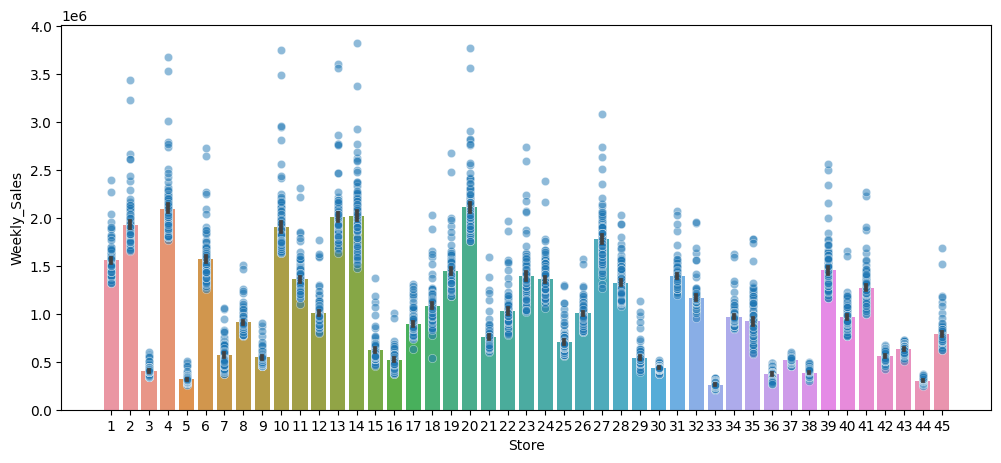

In [4]:
# Top performing stores according to the historical data visually:
offset = -1  # graph_alignment
df['Store_Offset'] = df['Store'] + offset
plt.figure(figsize=(12,5))
sns.barplot(data=df,x='Store',y='Weekly_Sales')
sns.scatterplot(data=df,x='Store_Offset',y='Weekly_Sales',alpha = 0.5)

**Top performing stores : 20,4,14 <br> Worst performing: 33**

ii. If the weekly sales are affected by the unemployment rate, if yes - which stores
are suffering the most?

In [5]:
# Correlation between Weekly Sales and Unemployment

iscorr = df['Weekly_Sales'].corr(df['Unemployment'])
store_performance = df.groupby('Store').agg({'Weekly_Sales': 'mean', 'Unemployment': 'mean'}).reset_index()
worststores = store_performance.sort_values('Weekly_Sales').head()

iscorr, worststores

(-0.10617608965795418,
     Store  Weekly_Sales  Unemployment
 32     33     259861.69          8.53
 43     44     302748.87          6.74
 4       5     318011.81          6.30
 35     36     373511.99          7.87
 37     38     385731.65         13.12)

**Weak Negative Correlation between the two. <br>
If unemployment increases sales will minimally decrease, if at all, for the particular sample.**
<br>
**33 is the worst performing store with an average of 8.5% unemployment throughout the sample.**

iii. Identify Seasonality in Weekly Sales:

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

monthly_sales_trend = df.groupby('Month').agg({'Weekly_Sales': 'mean'}).reset_index()
monthly_sales_trend

,Month,Weekly_Sales
0,1,947613.92
1,2,1054597.34
2,3,1024974.83
3,4,1024323.63
4,5,1035378.79
5,6,1064848.08
6,7,1014211.86
7,8,1044873.52
8,9,1009456.86
9,10,1030630.53


**Holiday Season is inevitable.** 
- December has highest average weekly sales. Most festive month (Diwali,Christmas,New Years Eve)
- November second highest spending in prep for December most likely.
- January the month of frivolity.
- Feb spike in spending. (Valentines and end of Winter)

iv.Temp vs Sales

In [7]:
temperature_sales_correlation = df['Weekly_Sales'].corr(df['Temperature'])
temperature_sales_correlation

-0.06381001317946956

**Too small a negative correlation to imply any sizable impact on each other.**

v. Consumer Price Index (CPI) vs Sales

In [8]:
cpi_sales_correlation = df['Weekly_Sales'].corr(df['CPI'])
cpi_sales_correlation

-0.07263416204017628

**Again too small a - corr to imply legitimate impact.**

#### <div align="center"> **Time Series Modeling** </div>

First graph the weekly sales of a few sample stores to identify overall characteristics of the time series:

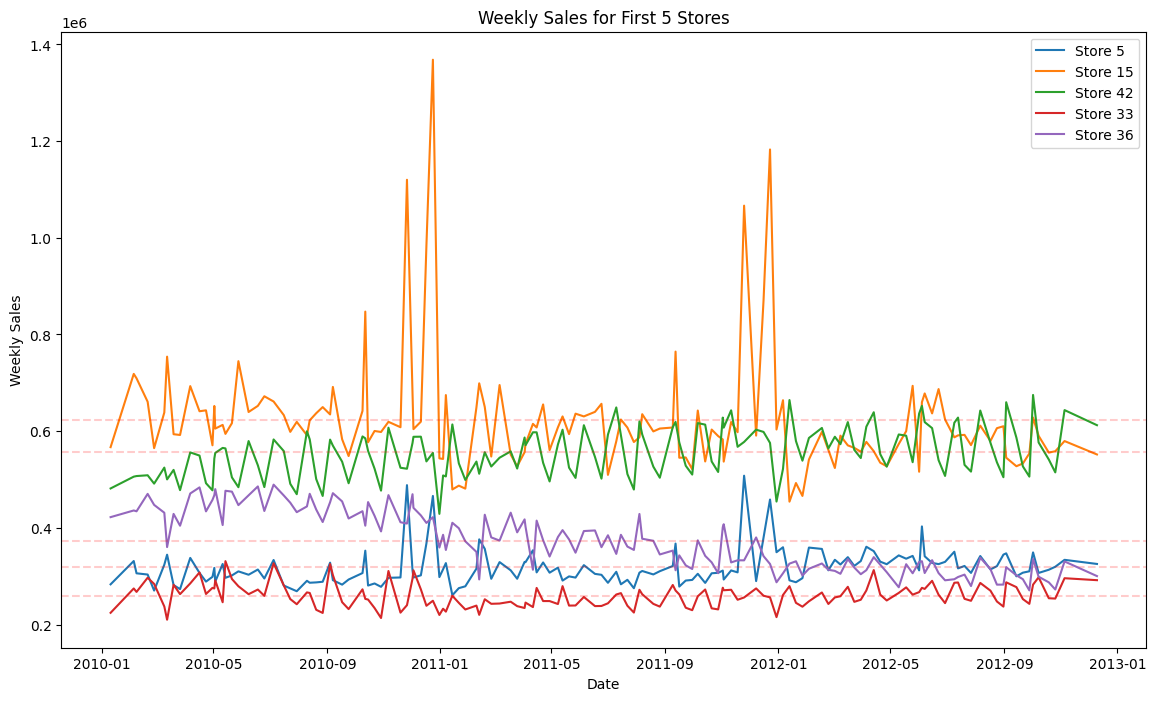

In [25]:
df = pd.read_csv('Walmart.csv')

#convert to and set sorted datetime as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)

# Plotting weekly sales for a few stores to visualize trends and seasonality
plt.figure(figsize=(14, 8))
for store in df['Store'].unique()[:5]:  # Select first 5 stores 
    subset = df[df['Store'] == store]
    plt.plot(subset.index, subset['Weekly_Sales'], label=f'Store {store}')
    plt.axhline(subset['Weekly_Sales'].mean(), color='r', alpha=0.2, linestyle='--')
plt.title('Weekly Sales for First 5 Stores')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()

As we can see, each store will have a unique time series with different components. 
<br>All the series seem to have a seasonal component around the same time period but obviously have different MA and AR componenets. 

We take an example (Store 1) to detail the process of:
- identifying the optimal time series components
- modeling the time series on those components (coefficients) 
- and finally forecasting 12 weeks of weekly sales with the best model.

Taking example of Store 1:

Perform **ADF** (augmented dickey fuller) Test to determine Stationarity of the Time Series. This will help us determine if we need to difference the time series to induce stationarity. 

In [29]:
# Selecting data for Store 1
store1_data = df[df['Store'] == 1]['Weekly_Sales']

# Perform ADF test for stationarity
adf_result = adfuller(store1_data)

# p-value
adf_result[1]

1.9818882304154748e-16

**ADF p-value** is well below 0.05 threshold. 
However, we know there is seasonality in the series every winter, so we will perform a quick visual check:

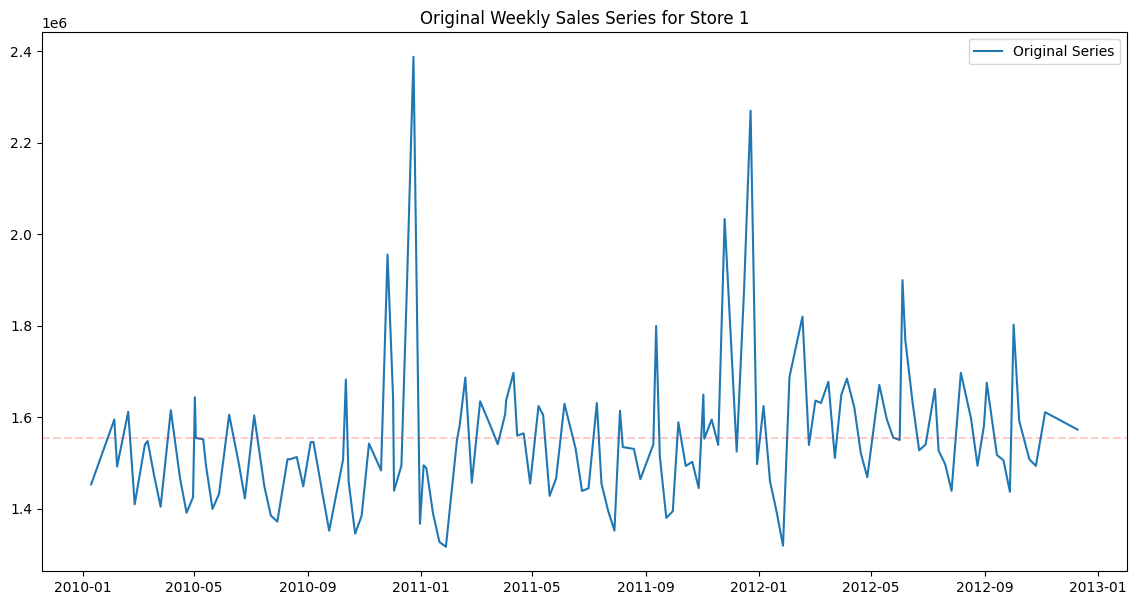

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(store1_data, label='Original Series')
plt.legend(loc='best')
plt.title('Original Weekly Sales Series for Store 1')
plt.axhline(store1_data.mean(), color='r', alpha=0.2, linestyle='--')

Visual test shows clear spike in values with **seasonality**.<br>
Series seems to slightly increase in mean value over time so let us try taking **single difference** to adjust. 

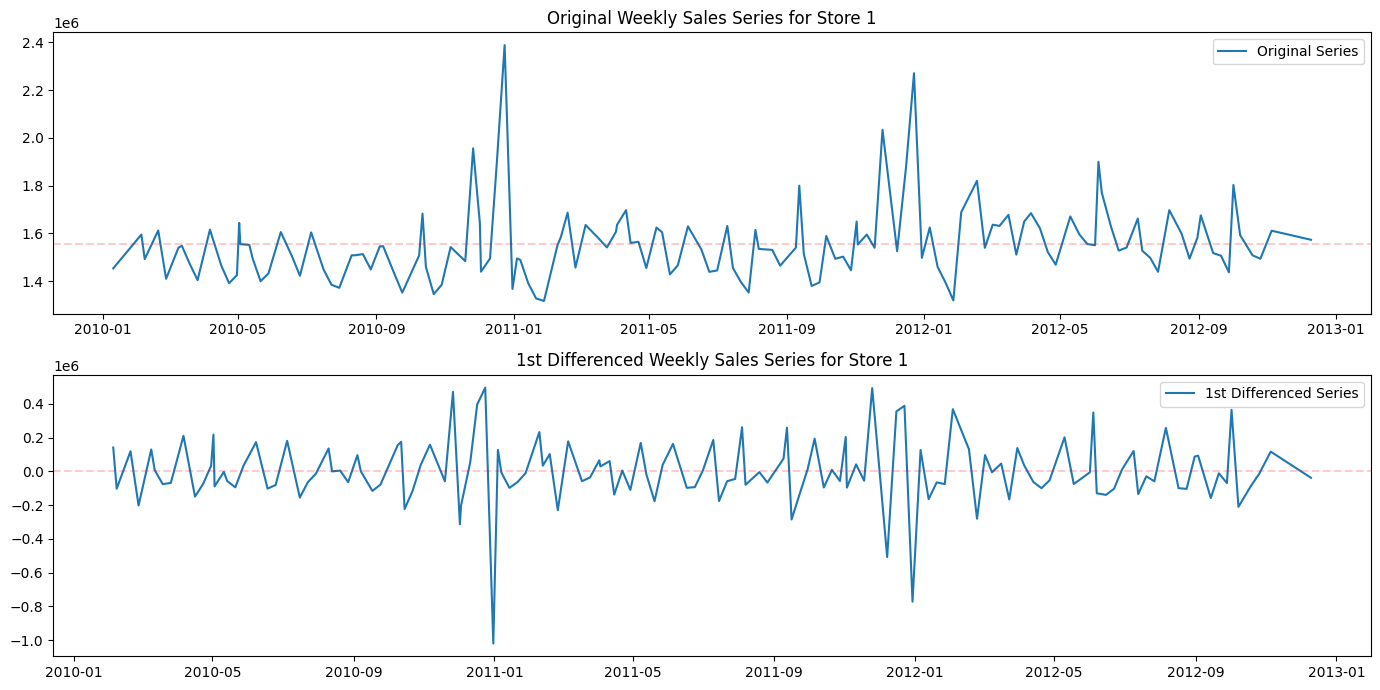

In [13]:
# Perform first differencing
store1_data_diff = store1_data.diff()[1:]

# Plotting the original and differenced series
plt.figure(figsize=(14, 7))
plt.subplot(211)
plt.plot(store1_data, label='Original Series')
plt.legend(loc='best')
plt.title('Original Weekly Sales Series for Store 1')
plt.axhline(store1_data.mean(), color='r', alpha=0.2, linestyle='--')

plt.subplot(212)
plt.plot(store1_data_diff, label='1st Differenced Series')
plt.legend(loc='best')
plt.title('1st Differenced Weekly Sales Series for Store 1')
plt.axhline(store1_data_diff.mean(), color='r', alpha=0.2, linestyle='--')
plt.tight_layout()

So, we have removed any variation in mean over time and centered the series around 0 mean.<br>

Since we are taking a **Seasonal model**, let us plot the **ACF**(autocorellation function) and **PACF**(partial ACF) and determine the Seasonal components **(P,D,Q)**. <br>

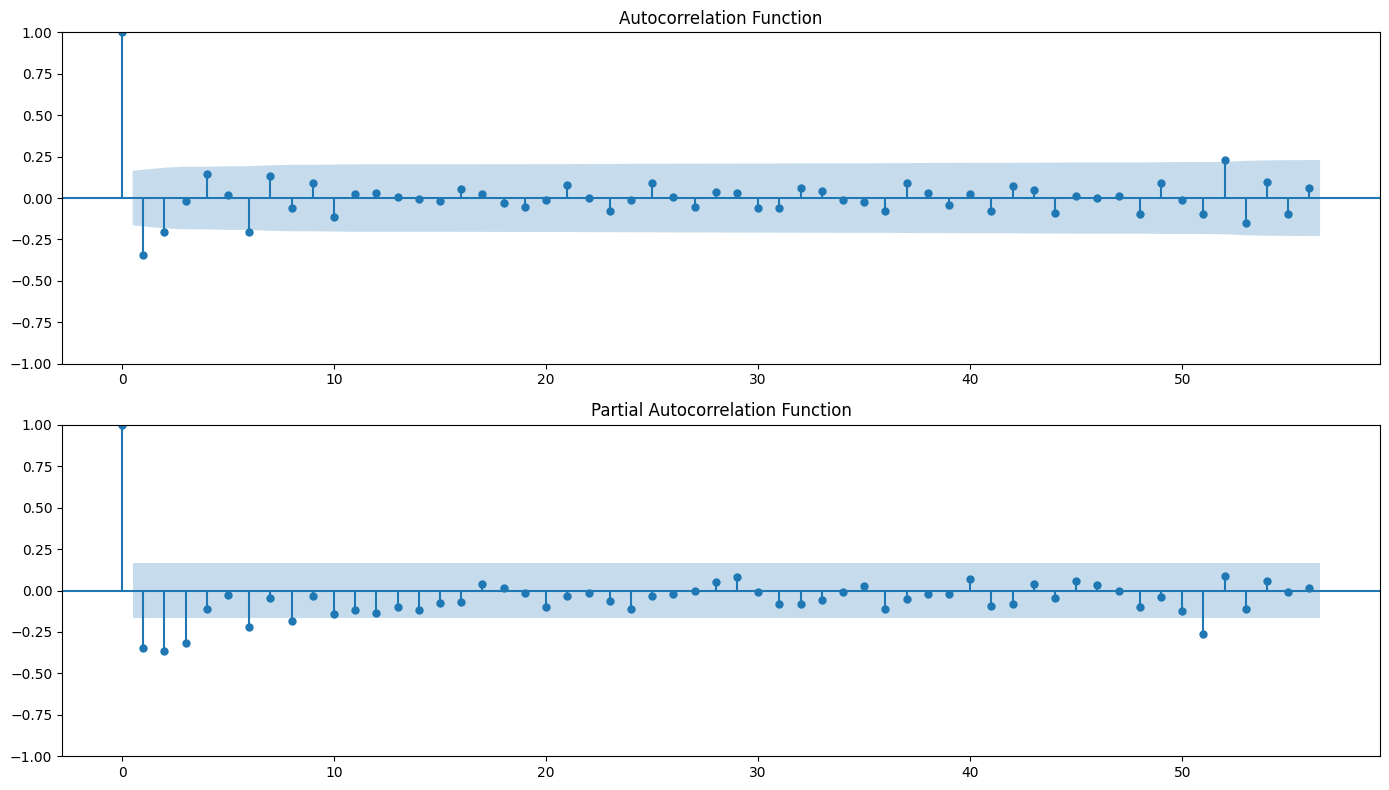

In [14]:
# Plotting ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# ACF plot
plot_acf(store1_data_diff, lags=56, ax=ax1)
ax1.set_title('Autocorrelation Function')

# PACF plot
plot_pacf(store1_data_diff, lags=56, ax=ax2, method='ywm')
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()

from PACF we read the seasonal AR component (P) and from ACF the seasonal MA comp (Q):
- P = 1 #seasonal single time lag
- D = 1 #seasonal single difference 
- Q = 1 #seasonal single mean error value 
- m = 52 #num weeks for seasonality

Fit SARIMA model for Store1 Sales:

In [66]:
sarima_model = SARIMAX(store1_data,order=(1,0,1),seasonal_order=(1,1,1,52))

sarima_results = sarima_model.fit(disp=0)

# Display the model summary
sarima_summary = sarima_results.summary()
sarima_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood               -1212.309
Date:                            Fri, 05 Apr 2024   AIC                           2434.618
Time:                                    11:35:39   BIC                           2447.172
Sample:                                         0   HQIC                          2439.682
                                            - 143                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6671      0.246     -2.717      0.007      -1.148      -0.186
ma.L1          0.8039      0.209      3.853      0.000       0.395       1.213
ar.S.L52       0.9914      0.195      5.082      0.000       0.609       1.374
ma.S.L52      -0.9762      0.308     -3.167      0.002      -1.580      -0.372
sigma2      2.285e+10   4.67e-11   4.89e+20      0.000    2.28e+10    2.28e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                23.28
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.80   Skew:                             0.70
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.19e+35. Standard errors may be unstable.
"""

From the summary, we see that all the components have minimum p values well below the 0.05 threshold. This means that the coefficients describe the series well. 

This was an example model run on Store 1 with established parameters. Now let us find the optimal model for Store 1 using autoarima and minimizing AIC:

In [85]:
model = auto_arima(store1_data, start_p=0, d=None, start_q=0, max_p=1, max_d=1, max_q=1,
                       seasonal=True, start_P=0, D=1, start_Q=0, max_P=1, max_D=1, max_Q=1, m=52,
                       trace=True, error_action='ignore', suppress_warnings=True, stepwise=False,random=True,n_fits=100)

 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=2431.645, Time=0.74 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=22.53 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2431.664, Time=7.80 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=2429.406, Time=2.38 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=2432.137, Time=5.67 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=2430.674, Time=0.48 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=2430.667, Time=0.49 sec
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=23.39 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=2429.479, Time=6.11 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=2432.188, Time=5.72 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=25.81 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=17.24 sec
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=2433.625, Time=11.37 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=2433.634, Time=11.83 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=2431.594, Time=5.21 sec
 ARIMA(0,

Here, autoarima selects the best model as: SARIMA(0,0,0)(0,1,0)[52] <br>

We can now **forecast** the next 12 weeks for store 1:

In [89]:
forecast = model.predict(n_periods=12)
forecast

143   1701985.58
144   1605562.28
145   1647309.54
146   1591854.35
147   2085691.31
148   1577517.74
149   1933547.32
150   2322559.64
151   1549833.37
152   1676848.23
153   1511971.82
154   1446764.49
dtype: float64

now let us do this for all 45 stores: 

In [95]:
# Load the dataset
data = pd.read_csv('Walmart.csv')
data['Date'] = pd.to_datetime(data['Date'])

# A dictionary to hold forecasts for each store
forecasts = {}

# Iterate through each store
for store in data['Store'].unique():
    # Filter the dataset for the current store and sort it
    store_data = data[data['Store'] == store].sort_values('Date')
    store_data.set_index('Date', inplace=True)
    
    # Fit the ARIMA model on the entire dataset for the current store
    
    model = auto_arima(store_data['Weekly_Sales'], start_p=0, d=None, start_q=0, max_p=2, max_d=1, max_q=2,
                   seasonal=True, start_P=0, D=1, start_Q=0, max_P=2, max_D=1, max_Q=2, m=52,
                   trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, n_fits=50)
    # Forecast the next 12 weeks
    forecast = model.predict(n_periods=12)
    
    # Store the forecast
    forecasts[store] = forecast
    print(f'Store {store} - Forecast for the next 12 weeks: {forecast}')

# Example of accessing the 12-week forecast for Store 1
print(f'Forecast for Store 1 for the next 12 weeks: {forecasts[1]}')

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=2428.740, Time=0.21 sec


 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2431.664, Time=7.38 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=2432.137, Time=5.43 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=2448.368, Time=0.14 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=2429.479, Time=6.15 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=2429.406, Time=2.36 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=16.63 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=2430.674, Time=0.46 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=2430.667, Time=0.48 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=2431.645, Time=0.75 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 39.999 seconds
Store 1 - Forecast for the next 12 weeks: 143   1701985.58
144   1605562.28
145   1647309.54
146   1591854.35
147   2085691.31
148   1577517.74
149   1933547.32
150   2322559.64
151   1549833.37
152   1676848.23
153   1511971.82
154   1446764.49
dtype: float64
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,

![Finished optimal SARIMA for each store](/sarima_finished_ss.png)

In [98]:
df_result = pd.DataFrame(forecasts)
df_result

,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
143,1701985.58,2139159.74,449256.67,2315615.93,326323.63,1546474.81,592569.27,1016765.96,583635.45,2092010.84,...,339774.17,529916.22,433049.77,1341470.13,946919.29,1235846.54,656038.71,643556.40,342688.69,767876.48
144,1605562.28,1990000.81,428682.75,2167587.05,308430.99,1516891.47,599601.17,921005.86,546139.93,1945347.55,...,343623.53,513012.30,425415.31,1397293.05,874301.12,1244932.78,635269.39,626162.92,321775.25,724038.67
145,1647309.54,2223865.70,438595.99,2330797.60,332428.82,1650499.33,597776.70,937707.05,622930.55,2107046.94,...,267614.55,508670.68,440225.73,1570533.62,1054089.58,1388342.41,671100.12,630483.39,347772.45,808075.01
146,1591854.35,2055004.29,424503.81,2371715.23,323250.55,1541883.72,581746.10,917650.76,570770.70,1876280.77,...,274230.75,534896.99,433333.26,1623973.51,921802.50,1315961.20,595648.70,641607.56,342796.50,771482.46
147,2085691.31,2344308.64,574922.98,3132470.97,516524.13,1791404.75,991017.74,1255782.43,843109.93,2918289.55,...,273037.53,529955.94,433570.33,2452408.64,1246414.46,1992556.53,605673.20,645132.36,339212.83,1170842.37
148,1577517.74,1948260.77,405474.88,2233437.38,305453.69,1512000.36,712615.48,877414.67,548641.22,1917140.44,...,317936.51,509906.29,431886.96,1627632.21,971909.46,1442533.06,631122.09,619328.39,326173.88,724628.50
149,1933547.32,2446362.53,534922.23,2899165.81,394294.65,1796424.90,762187.65,1138782.51,733914.40,2563141.42,...,280160.09,541307.57,434698.91,2105400.29,1215072.70,1768211.50,626412.81,639004.24,341896.74,1078858.55
150,2322559.64,3064462.38,577899.81,3804157.62,473829.72,2105249.77,1101660.80,1482872.62,933681.11,3495901.40,...,265024.66,613193.36,443694.29,2668059.08,1617988.21,2349565.86,603650.96,648494.42,407748.26,1521863.82
151,1549833.37,1929226.50,434303.27,2134874.50,363217.07,1548220.72,857861.05,879190.79,578144.79,1923796.98,...,226206.26,458729.51,415977.59,1650715.80,925255.66,1349857.34,482387.11,587998.48,298570.30,869415.99
152,1676848.23,1962021.20,454846.46,2307129.58,373628.28,1575743.04,640440.56,941779.77,612005.02,1769323.98,...,245092.62,539213.75,449323.27,1754053.01,1053866.78,1460734.54,549928.61,624242.51,351984.48,837164.38


#### <div align="center"> **Results & Conclusion:** </div>

In [104]:
ci = range(143, 155)  # 155 because range() is exclusive on the stop value
ni = [f'pred_week{i}' for i in range(1, 13)]
index_map = dict(zip(ci, ni))
df_result.rename(index=index_map, inplace=True)

nn= {i: f'store {i}' for i in range(1, 46)}
df_result.rename(columns=nn, inplace=True)
df_result

,store 1,store 2,store 3,store 4,store 5,store 6,store 7,store 8,store 9,store 10,...,store 36,store 37,store 38,store 39,store 40,store 41,store 42,store 43,store 44,store 45
pred_week1,1701985.58,2139159.74,449256.67,2315615.93,326323.63,1546474.81,592569.27,1016765.96,583635.45,2092010.84,...,339774.17,529916.22,433049.77,1341470.13,946919.29,1235846.54,656038.71,643556.40,342688.69,767876.48
pred_week2,1605562.28,1990000.81,428682.75,2167587.05,308430.99,1516891.47,599601.17,921005.86,546139.93,1945347.55,...,343623.53,513012.30,425415.31,1397293.05,874301.12,1244932.78,635269.39,626162.92,321775.25,724038.67
pred_week3,1647309.54,2223865.70,438595.99,2330797.60,332428.82,1650499.33,597776.70,937707.05,622930.55,2107046.94,...,267614.55,508670.68,440225.73,1570533.62,1054089.58,1388342.41,671100.12,630483.39,347772.45,808075.01
pred_week4,1591854.35,2055004.29,424503.81,2371715.23,323250.55,1541883.72,581746.10,917650.76,570770.70,1876280.77,...,274230.75,534896.99,433333.26,1623973.51,921802.50,1315961.20,595648.70,641607.56,342796.50,771482.46
pred_week5,2085691.31,2344308.64,574922.98,3132470.97,516524.13,1791404.75,991017.74,1255782.43,843109.93,2918289.55,...,273037.53,529955.94,433570.33,2452408.64,1246414.46,1992556.53,605673.20,645132.36,339212.83,1170842.37
pred_week6,1577517.74,1948260.77,405474.88,2233437.38,305453.69,1512000.36,712615.48,877414.67,548641.22,1917140.44,...,317936.51,509906.29,431886.96,1627632.21,971909.46,1442533.06,631122.09,619328.39,326173.88,724628.50
pred_week7,1933547.32,2446362.53,534922.23,2899165.81,394294.65,1796424.90,762187.65,1138782.51,733914.40,2563141.42,...,280160.09,541307.57,434698.91,2105400.29,1215072.70,1768211.50,626412.81,639004.24,341896.74,1078858.55
pred_week8,2322559.64,3064462.38,577899.81,3804157.62,473829.72,2105249.77,1101660.80,1482872.62,933681.11,3495901.40,...,265024.66,613193.36,443694.29,2668059.08,1617988.21,2349565.86,603650.96,648494.42,407748.26,1521863.82
pred_week9,1549833.37,1929226.50,434303.27,2134874.50,363217.07,1548220.72,857861.05,879190.79,578144.79,1923796.98,...,226206.26,458729.51,415977.59,1650715.80,925255.66,1349857.34,482387.11,587998.48,298570.30,869415.99
pred_week10,1676848.23,1962021.20,454846.46,2307129.58,373628.28,1575743.04,640440.56,941779.77,612005.02,1769323.98,...,245092.62,539213.75,449323.27,1754053.01,1053866.78,1460734.54,549928.61,624242.51,351984.48,837164.38


Thus, we have our forecast weekly sales for all 45 stores, 12 weeks into the future.<br>

Notes:
- The dataset was very small for each store(limited to 143 weeks). Hence the entire dataset was used to train each model. Thus, the model was not evaluated on any test data. The predictions are solely based on training and so we consider:
  - overfitting on training data leading inaccurate for the forecasted values
  - sensitivity to noise in small sample
- It is also recommended to forecast values a very short period into the future to maintain a certain threshold of confidence in the predicted values, as the further into the future a model predicts the less accurate it is. 




Author: <br>
Pratyax Kandpal <br>
[pratyaxk2000@linkedin.in](https://www.linkedin.com/in/pratyaxk2000/)<br>
<br>
Inspiration and Learning:<br>
- https://github.com/ritvikmath/Time-Series-Analysis/tree/master
- https://otexts.com/fpp3/

